# Set Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
#rs = 2020
PD_dep = 'good'
LGD_s1_dep = 'recoverable'
LGD_s2_dep = 'recovery_rate'
EAD_dep = 'CCF'

In [3]:
data_backup = pd.read_csv('processed_data/data_processed.csv', index_col = 0)
lgd_ead_feature=pd.read_csv('processed_data/lgd_ead_feature.csv', index_col = 0)
reference = pd.read_csv('processed_data/reference_categories.csv', index_col = 0)
train_idx = pd.read_csv('processed_data/train_idx.csv')['train_index']
test_idx = pd.read_csv('processed_data/test_idx.csv')['test_index']
data = data_backup.copy()

/Users/warren/opt/anaconda3/envs/credit_risk/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (20,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# default customers
default_type = ['Charged Off','Does not meet the credit policy. Status:Charged Off']
data_default = data[data.loan_status.isin(default_type)]
data_default.head()
#LGD cosider 'lost given DEFAULT'
# consider only default customers
# because:1. the big proportion of "non-default customer" makes model skewed
# because:2. PD already deal with "Default or not", if LGD still consider this information is redundant! 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,good,recovery_rate,recoverable,CCF,term_int_numeric,emp_length_int_numeric,mths_since_issue_d_numeric,int_rate_numeric,funded_amnt_numeric,mths_since_earliest_cr_line_numeric,delinq_2yrs_numeric,inq_last_6mths_numeric,open_acc_numeric,pub_rec_numeric,total_acc_numeric,acc_now_delinq_numeric,total_rev_hi_lim_numeric,installment_numeric,annual_inc_numeric,mths_since_last_delinq_numeric,dti_numeric,mths_since_last_record_numeric,home_ownership:MORTGAGE,home_ownership:OWN,home_ownership:RENT_OTHER_NONE_ANY,addr_state:AR_MI_PA_OH_MN,addr_state:CA,addr_state:GA_WA_OR,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:RI_MA_DE_SD_IN,addr_state:TX,addr_state:UT_KY_AZ_NJ,addr_state:WI_MT,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:credit_card,purpose:debt_consolidation,purpose:educ__sm_b__ren_en__mov,purpose:major_purch__car__home_impr,purpose:oth__med__vacation__house__wedd,initial_list_status:f,initial_list_status:w,term_int:36,term_int:60,emp_length_int:2-5,emp_length_int:6-7,emp_length_int:8-10,emp_length_int:<=0,emp_length_int:=1,emp_length_int:>=10,mths_since_issue_d:38.0-40,mths_since_issue_d:40.0-42,mths_since_issue_d:42.0-49,mths_since_issue_d:49.0-53,mths_since_issue_d:53.0-65,mths_since_issue_d:65.0-85,mths_since_issue_d:<=38,mths_since_issue_d:>=85.0,int_rate:12.026-15.74,int_rate:15.741-20.281,int_rate:9.548-12.025,int_rate:<9.548,int_rate:>=20.282,mths_since_earliest_cr_line:140.0-165,mths_since_earliest_cr_line:165.0-248,mths_since_earliest_cr_line:248.0-271,mths_since_earliest_cr_line:<140.0,mths_since_earliest_cr_line:>353,delinq_2yrs:1-3,delinq_2yrs:<=0,delinq_2yrs:>=4,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:<=0,inq_last_6mths:>=7,open_acc:1-3,open_acc:13-17,open_acc:18-22,open_acc:23-25,open_acc:26-30,open_acc:4-12,open_acc:<=0,open_acc:>=31,pub_rec:0-2,pub_rec:3-4,pub_rec:>=5,total_acc:28-51,total_acc:<=27,total_acc:>=52,acc_now_delinq:<=0,acc_now_delinq:>=1,total_rev_hi_lim:10.0K-20K,total_rev_hi_lim:20.0K-30K,total_rev_hi_lim:30.0K-40K,total_rev_hi_lim:40.0K-55K,total_rev_hi_lim:5.0K-10K,total_rev_hi_lim:55.0K-95K,total_rev_hi_lim:<=5K,total_rev_hi_lim:>=95K,annual_inc:100.0K-120K,annual_inc:120.0K-140K,annual_inc:20.0K-50K,annual_inc:50.0K-60K,annual_inc:60.0K-70K,annual_inc:70.0K-80K,annual_inc:80.0K-90K,annual_inc:90.0K-100K,annual_inc:<=20K,annual_inc:>=140K,mths_since_last_delinq:0-3,mths_since_last_delinq:31-56,mths_since_last_delinq:4-30,mths_since_last_delinq:>=57,mths_since_last_delinq:Missing,dti:1.4-3.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:3.5-7.7,dti:7.7-10.5,dti:<=1.4,dti:>=35.0,mths_since_last_record:0-2,mths_since_last_record:21-31,mths_since_last_record:3-20,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_las

In [5]:
data_default.shape

(43236, 218)

In [6]:
data_default.isnull().sum()

id                                             0
member_id                                      0
loan_amnt                                      0
funded_amnt                                    0
funded_amnt_inv                                0
term                                           0
int_rate                                       0
installment                                    0
grade                                          0
sub_grade                                      0
emp_title                                   3287
emp_length                                  2337
home_ownership                                 0
annual_inc                                     0
verification_status                            0
issue_d                                        0
loan_status                                    0
pymnt_plan                                     0
url                                            0
desc                                       27396
purpose             

# Preprocessing

## independent

In [7]:
#fill NA with 0
data_default['mths_since_last_delinq_numeric'].fillna(0, inplace = True)
data_default['mths_since_last_record_numeric'].fillna(0, inplace = True)


/Users/warren/opt/anaconda3/envs/credit_risk/lib/python3.8/site-packages/pandas/core/series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Exploratary Analysis on dependent

In [8]:
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

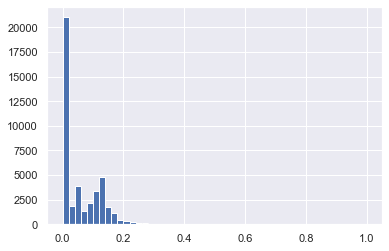

In [9]:
plt.hist(data_default['recovery_rate'], bins = 50)
# note that if recovery_rate == 0 are few, no need to do stage 1 model

(array([  20.,   60.,   29.,   97.,   70.,   84.,  150.,   78.,  124.,
         170.,  152.,  208.,  199.,  228.,  242.,  276.,  300.,  335.,
         339.,  376.,  412.,  421.,  505.,  505.,  575.,  583.,  614.,
         735.,  756.,  812.,  840.,  942.,  959., 1137., 1217., 1418.,
        1431., 1580., 1732., 1850., 2003., 2151., 2123., 2376., 2447.,
        2693., 2366., 2115., 1527.,  874.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

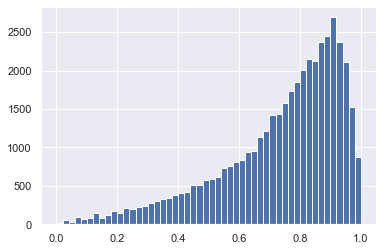

In [10]:
plt.hist(data_default.CCF, bins = 50)

# LGD Model

## stage 1 model
to predict if this customer is recoverable; dependent var : recoverable == True ( recovery_rate > 0 )

### train test prepare

In [11]:
default_train_idx = data_default.index.isin(train_idx)
default_test_idx = data_default.index.isin(test_idx)

sum(default_train_idx) + sum(default_test_idx) == data_default.shape[0]

True

In [12]:
# feature names
LGD_EAD_features = lgd_ead_feature['feature'].to_list()
idx = reference['reference'].isin(LGD_EAD_features)
LGD_EAD_reference = reference['reference'][idx].to_list()

#slice
X_train_LGD_S1 = data_default.loc[default_train_idx,LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)
X_test_LGD_S1 = data_default.loc[default_test_idx,LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)
Y_train_LGD_S1 = data_default.loc[default_train_idx,LGD_s1_dep]
Y_test_LGD_S1 = data_default.loc[default_test_idx,LGD_s1_dep]

## Logistic model 

In [13]:
from sklearn import linear_model
import scipy.stats as stats

class LogisticRegression_with_p_values:
    
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)
    def fit(self, X,y):
        self.model.fit(X,y)
        #calculate P-values
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stats.norm.sf(abs(x)) * 2 for x in z_scores]
        #store
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values
        
        #summary
        tb = pd.DataFrame(columns= ['feature'], data = X.columns.values)
        tb['coefficient'] = np.transpose(self.coef_)
        # revalue the index to make the df index starts from 1, like in R
        tb.index = tb.index + 1
        # add the Intercept in index 0
        tb.loc[0] = ['Intercept', self.intercept_[0]]
        #sort idx
        tb = tb.sort_index() 
        # p_values
        tb['p_value'] = np.append(np.nan, np.array(p_values)).round(4) # intercept's p-value = nan
        #
        self.summary = tb
    
    
    # predict and report for test set
    def predict_n_result(self, X_test, Y_test):
        actual = np.array(Y_test)
        pred = self.model.predict(X_test)
        prob = self.model.predict_proba(X_test)[:][:,1]
        #result table
        result = pd.DataFrame(
            columns= ['actual', 'pred', 'prob'],
            data = np.transpose([ actual , pred , prob ]) 
                )
        # get a sorted table

        ## sort the prob
        ### to calculate GINI and KS, sort the prob by ascending
        result_sorted = result.sort_values('prob').reset_index() # automatically save orig_idx when reset
        ## cumulated count
        result_sorted['cumul_N_total'] = result_sorted.index+1
        result_sorted['cumul_N_good'] = result_sorted['actual'].cumsum()
        result_sorted['cumul_N_bad'] = result_sorted['cumul_N_total']-result_sorted['cumul_N_good']
        ## cumulated percent

        result_sorted['cumul_perc_total'] = result_sorted['cumul_N_total'] / result_sorted.shape[0]
        result_sorted['cumul_perc_good'] = result_sorted['cumul_N_good'] / result_sorted['cumul_N_good'].max()
        result_sorted['cumul_perc_bad'] = result_sorted['cumul_N_bad'] / result_sorted['cumul_N_bad'].max()

        # metrics
        P = actual == 1
        N = actual == 0
        TPR = np.mean(P & pred == 1) #TP / p
        FPR = np.mean(N & pred == 1) #FP / N
        from sklearn.metrics import roc_auc_score 
        AUC = roc_auc_score(actual, prob) 
        GINI = AUC*2 - 1
        KS = max(result_sorted['cumul_perc_bad'] - result_sorted['cumul_perc_good'])

        metrics = {"TPR":TPR, 'FPR':FPR, 'AUC':AUC, 'GINI':GINI, 'KS':KS}
        return result, result_sorted, metrics


In [14]:
logit_lgd_st_1 = LogisticRegression_with_p_values()
logit_lgd_st_1.fit(X_train_LGD_S1, Y_train_LGD_S1)

/Users/warren/opt/anaconda3/envs/credit_risk/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
logit_lgd_st_1.summary

,feature,coefficient,p_value
0,Intercept,-2.420393e-04,NaN
1,home_ownership:MORTGAGE,-8.762918e-05,0.9973
2,home_ownership:OWN,6.374736e-06,0.9999
3,addr_state:AR_MI_PA_OH_MN,-8.234458e-05,0.9986
4,addr_state:CA,5.007770e-05,0.9991
5,addr_state:GA_WA_OR,-1.295493e-04,0.9981
6,addr_state:IL_CT,-7.413188e-05,0.9990
7,addr_state:KS_SC_CO_VT_AK_MS,-9.762368e-06,0.9999
8,addr_state:NM_VA,6.621553e-06,0.9999
9,addr_state:NY,-2.286083e-04,0.9963


## stage 1 evaluation

In [16]:
result, result_sorted, metrics = logit_lgd_st_1.predict_n_result(X_test_LGD_S1, Y_test_LGD_S1)

In [17]:
metrics

{'TPR': 0.4586457492213635,
 'FPR': 0.2750028838389664,
 'AUC': 0.6449071948572924,
 'GINI': 0.28981438971458484,
 'KS': 0.22059396464356007}

## stage 2 model
to predict recovery rate; dependent var : recovery rate

In [18]:
#der_var = [LGD_s1_dep, LGD_s2_dep, EAD_dep ]
# here training set use "Recovery_rate > 0", 
# because: 1. LGD_S1 already deal with "Recoverable or not", LGD_S2 should not deal with same information
# because: 2. a lot of 0 in recovery_rate makes model skewed!

recoverable_customers = data_default.recoverable != 0

X_train_LGD_S2 = data_default.loc[
    (default_train_idx & recoverable_customers),LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)
X_test_LGD_S2 = data_default.loc[
    (default_train_idx & recoverable_customers),LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)

Y_train_LGD_S2 = data_default.loc[(default_train_idx & recoverable_customers),LGD_s2_dep]
Y_test_LGD_S2 = data_default.loc[(default_train_idx & recoverable_customers),LGD_s2_dep]

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stat

class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se # t-score
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))) #p-value
        
        #summary
        tb = pd.DataFrame(columns= ['feature'], data = X.columns.values)
        tb['coefficient'] = np.transpose(self.coef_)
        ##reindex, add intercept
        tb.index = tb.index + 1
        tb.loc[0] = ['intercept', self.intercept_]
        tb = tb.sort_index()
        ## p-values
        p_value = self.p # p for each coefficient
        p_value = np.append(np.nan, np.array(p_value)) # p for intercept, a nan value
        tb['p_value'] = p_value.round(4)
        
        self.summary = tb
    
    # predict and result
    def predict_n_result(self, X_test, Y_test):
        pred = self.predict(X_test)
        actual = np.array(Y_test)
        residual = actual - pred
        result = pd.DataFrame(columns= ['actual', 'pred', 'residual'],
                              data = np.transpose([actual, pred, residual]))
        return result

In [20]:
lm_lgd_st_2 = LinearRegression()
lm_lgd_st_2.fit(X_train_LGD_S2, Y_train_LGD_S2)

In [21]:
lm_lgd_st_2.summary

,feature,coefficient,p_value
0,intercept,1.400051e-01,NaN
1,home_ownership:MORTGAGE,-4.949982e-04,0.7465
2,home_ownership:OWN,5.650216e-03,0.0195
3,addr_state:AR_MI_PA_OH_MN,4.805952e-03,0.0707
4,addr_state:CA,-1.563549e-03,0.5168
5,addr_state:GA_WA_OR,4.352372e-03,0.1778
6,addr_state:IL_CT,-2.024238e-03,0.5720
7,addr_state:KS_SC_CO_VT_AK_MS,-1.949504e-03,0.6002
8,addr_state:NM_VA,2.335095e-03,0.5425
9,addr_state:NY,-5.800408e-03,0.0468


## stage 2 evluation

In [22]:
lgd_result = lm_lgd_st_2.predict_n_result(X_test_LGD_S2, Y_test_LGD_S2)

In [23]:
lgd_result.corr()

,actual,pred,residual
actual,1.000000,3.032984e-01,9.528956e-01
pred,0.303298,1.000000e+00,-4.116383e-17
residual,0.952896,-4.116383e-17,1.000000e+00


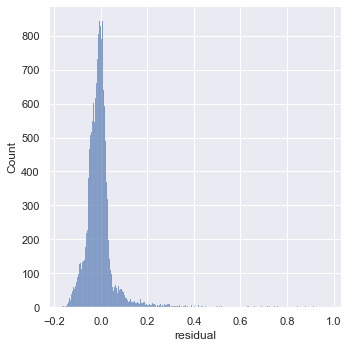

In [24]:
sns.displot(lgd_result['residual'])

## Combining Stage 1 and Stage 2

In [25]:
pred_stage_1 = logit_lgd_st_1.model.predict(X_test_LGD_S1) # recoverable_bool
pred_stage_2 = lm_lgd_st_2.predict(X_test_LGD_S1) #recovery_rate
pred_lgd = pred_stage_1*pred_stage_2
#fix where the recovery_rate out of bounds
pred_lgd = np.where(pred_lgd < 0, 0, pred_lgd)
pred_lgd = np.where(pred_lgd > 1, 1, pred_lgd)

# result
lgd_result = pd.DataFrame(columns= ['pred_lgd_s1', 'pred_lgd_s2', 'pred_recovery_rate'],
                         data = np.transpose([pred_stage_1, pred_stage_2, pred_lgd]))
lgd_result.describe()

,pred_lgd_s1,pred_lgd_s2,pred_recovery_rate
count,8669.000000,8669.000000,8669.000000
mean,0.733649,0.113975,0.077106
std,0.442076,0.029118,0.051946
min,0.000000,0.000738,0.000000
25%,0.000000,0.096151,0.000000
50%,1.000000,0.116517,0.094523
75%,1.000000,0.133789,0.117723
max,1.000000,0.277137,0.183612


# EAD model

In [26]:
#slice
X_train_EAD = data_default.loc[default_train_idx,LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)
X_test_EAD = data_default.loc[default_test_idx,LGD_EAD_features].drop(LGD_EAD_reference, axis = 1)
Y_train_EAD = data_default.loc[default_train_idx,EAD_dep]
Y_test_EAD = data_default.loc[default_test_idx,EAD_dep]

In [27]:
lm_ead = LinearRegression()
lm_ead.fit(X_train_EAD, Y_train_EAD)

## evaluation

In [28]:
ead_result = lm_ead.predict_n_result(X_test_EAD, Y_test_EAD)
# fix pred value > 1, <0
ead_result['pred'] = np.where(ead_result['pred']>1, 1, ead_result['pred'])
ead_result['pred'] = np.where(ead_result['pred']<0, 0, ead_result['pred'])
ead_result['residual'] = ead_result['actual'] - ead_result['pred']
#
ead_result.describe()

,actual,pred,residual
count,8669.000000,8669.000000,8669.000000
mean,0.736046,0.737741,-0.001695
std,0.200881,0.101821,0.172350
min,0.004167,0.398772,-0.837979
25%,0.628988,0.669491,-0.085988
50%,0.791017,0.730282,0.016718
75%,0.889405,0.811773,0.106843
max,1.000000,1.000000,0.529492


In [29]:
ead_result.corr()

,actual,pred,residual
actual,1.000000,0.513751,0.862032
pred,0.513751,1.000000,0.008019
residual,0.862032,0.008019,1.000000


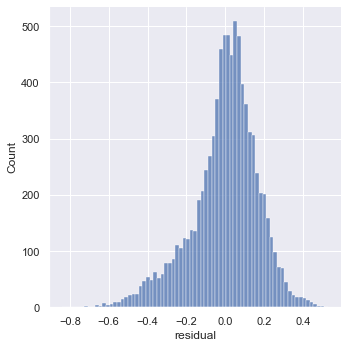

In [30]:
sns.displot(ead_result['residual'])

# save result

In [31]:
import pickle
pickle.dump(logit_lgd_st_1, open('model_result/lgd_model_stage_1.sav', 'wb'))
pickle.dump(lm_lgd_st_2, open('model_result/lgd_model_stage_2.sav', 'wb'))
pickle.dump(lm_ead, open('model_result/ead_model.sav', 'wb'))

# Make LGD S1,S2 a class (didn't use, just for explore)